In [1]:
# We need to install this library to get our satellite data easily
!pip install tensorflow_datasets

# Now we import our "toolkits"
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Set our standards (same as before)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# --- START OF CHANGES ---

# 1. Define our new 3 categories
NEW_CLASS_NAMES = ['Good_for_Solar', 'Bad_for_Solar', 'Unusable_Land']

# 2. This is our Python re-labeling function (same as before)
def map_label_logic(label):
    label = label.numpy()
    # 10 OLD LABELS: 0:AnnualCrop, 1:Forest, 2:HerbaceousVegetation, 3:Highway,
    # 4:Industrial, 5:Pasture, 6:PermanentCrop, 7:Residential, 8:River, 9:SeaLake

    # NEW LABEL 0: Good_for_Solar
    if label in [0, 2, 5]: # (AnnualCrop, HerbaceousVeg, Pasture)
        return np.int64(0)

    # NEW LABEL 1: Bad_for_Solar
    if label in [1, 4, 7]: # (Forest, Industrial, Residential)
        return np.int64(1)

    # NEW LABEL 2: Unusable_Land
    else: # (Highway, PermanentCrop, River, SeaLake)
        return np.int64(2)

# 3. This function is for TRAINING and VALIDATION data
# It resizes, normalizes, and remaps the label
def preprocess_for_training(image, label):
    # This 'bicubic' method can make stretched images look a little sharper
    image = tf.image.resize(image, IMG_SIZE, method='bicubic')
    image = tf.cast(image, tf.float32) / 255.0

    new_label = tf.py_function(map_label_logic, [label], tf.int64)
    new_label.set_shape(())

    return image, new_label

# 4. This new function is ONLY for TEST data
# It just resizes and normalizes, keeping the ORIGINAL label
def preprocess_test_image(image, label):
    image = tf.image.resize(image, IMG_SIZE, method='bicubic')
    image = tf.cast(image, tf.float32) / 255.0
    return image, label # Returns image and ORIGINAL label

# --- END OF CHANGES ---

# Load the dataset (this part is the same)
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Get the *original* class names to use in our plot
ORIGINAL_CLASS_NAMES = ds_info.features['label'].names
print("Original 10 Categories:", ORIGINAL_CLASS_NAMES)
print("New 3 Categories:", NEW_CLASS_NAMES)

# Create the final data pipelines
ds_train = ds_train.map(preprocess_for_training, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess_for_training, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- ONE LAST CHANGE HERE ---
# Tell ds_test to use our NEW test function
ds_test = ds_test.map(preprocess_test_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Data pipelines created successfully.")

Original 10 Categories: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
New 3 Categories: ['Good_for_Solar', 'Bad_for_Solar', 'Unusable_Land']
Data pipelines created successfully.


In [3]:
# 1. Get the pre-trained "base model" (MobileNetV2)
# (This part is the same)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# 2. Freeze the base model (This part is the same)
base_model.trainable = False

# --- START OF CHANGE ---

# 3. Build your new "head"
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),

    # This is the key change:
    # We now have 3 categories, not 10.
    tf.keras.layers.Dense(len(NEW_CLASS_NAMES), activation='softmax')
])

# --- END OF CHANGE ---

# 4. Compile the model (This part is the same)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
# This step will take 5-10 minutes. Watch the 'val_accuracy' go up!
print("Starting training...")
history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val
)
print("Training finished!")

Starting training...
Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 79s 91ms/step - accuracy: 0.8094 - loss: 0.4515 - val_accuracy: 0.9089 - val_loss: 0.2355
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.9026 - loss: 0.2496 - val_accuracy: 0.9185 - val_loss: 0.2106
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - accuracy: 0.9131 - loss: 0.2232 - val_accuracy: 0.9230 - val_loss: 0.1982
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - accuracy: 0.9189 - loss: 0.2145 - val_accuracy: 0.9222 - val_loss: 0.1993
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9173 - loss: 0.2101 - val_accuracy: 0.9226 - val_loss: 0.1926
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9192 - loss: 0.2037 - val_accuracy: 0.9252 - val_loss: 0.1886
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - accuracy: 0.9215 - loss: 0.2067 - val_accuracy: 0.9281 - val_loss: 0.1841
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - accuracy: 0.9

In [5]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(ds_test)

print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9358 - loss: 0.1836
Final Test Accuracy: 93.22%


Gathering predictions from the entire test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/s

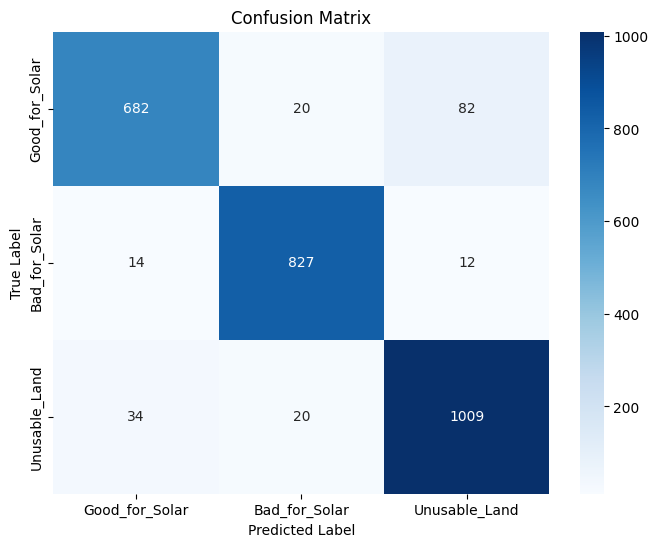

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Create empty lists to store all predictions and true labels
all_true_labels = []
all_pred_labels = []

# 2. Loop through the entire test set
print("Gathering predictions from the entire test set...")
for images, original_labels in ds_test:
    # Get the model's predictions
    predictions = model.predict(images)

    # Get the predicted class index
    predicted_indices = np.argmax(predictions, axis=1)

    # Convert the original labels to our 3 new classes
    true_indices = [map_label_logic(label) for label in original_labels]

    # Add this batch to our master lists
    all_pred_labels.extend(predicted_indices)
    all_true_labels.extend(true_indices)

print("...Done!")

# 3. Print the Classification Report
# This shows precision, recall, and f1-score for each class
print("\n--- Classification Report ---")
print(classification_report(all_true_labels, all_pred_labels, target_names=NEW_CLASS_NAMES))

# 4. Plot the Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_true_labels, all_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=NEW_CLASS_NAMES,
            yticklabels=NEW_CLASS_NAMES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

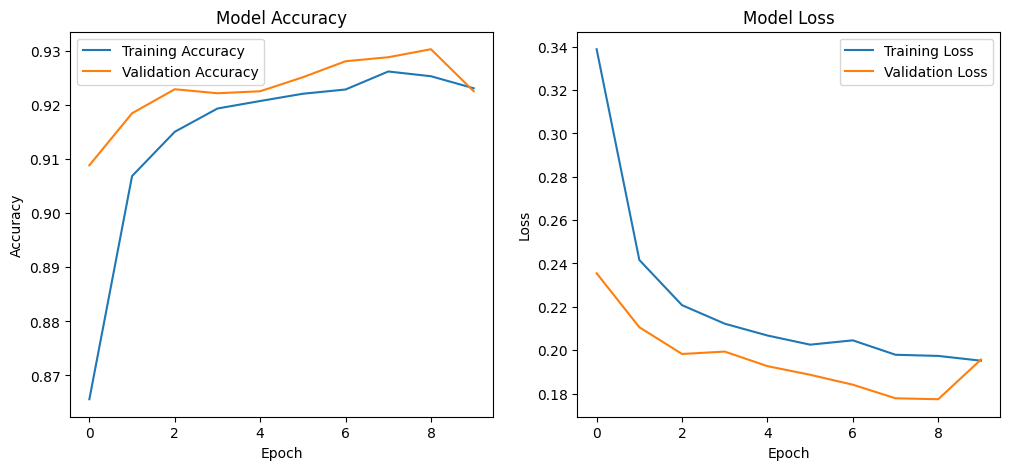

In [6]:
# Create a figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot Accuracy ---
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# --- Plot Loss ---
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


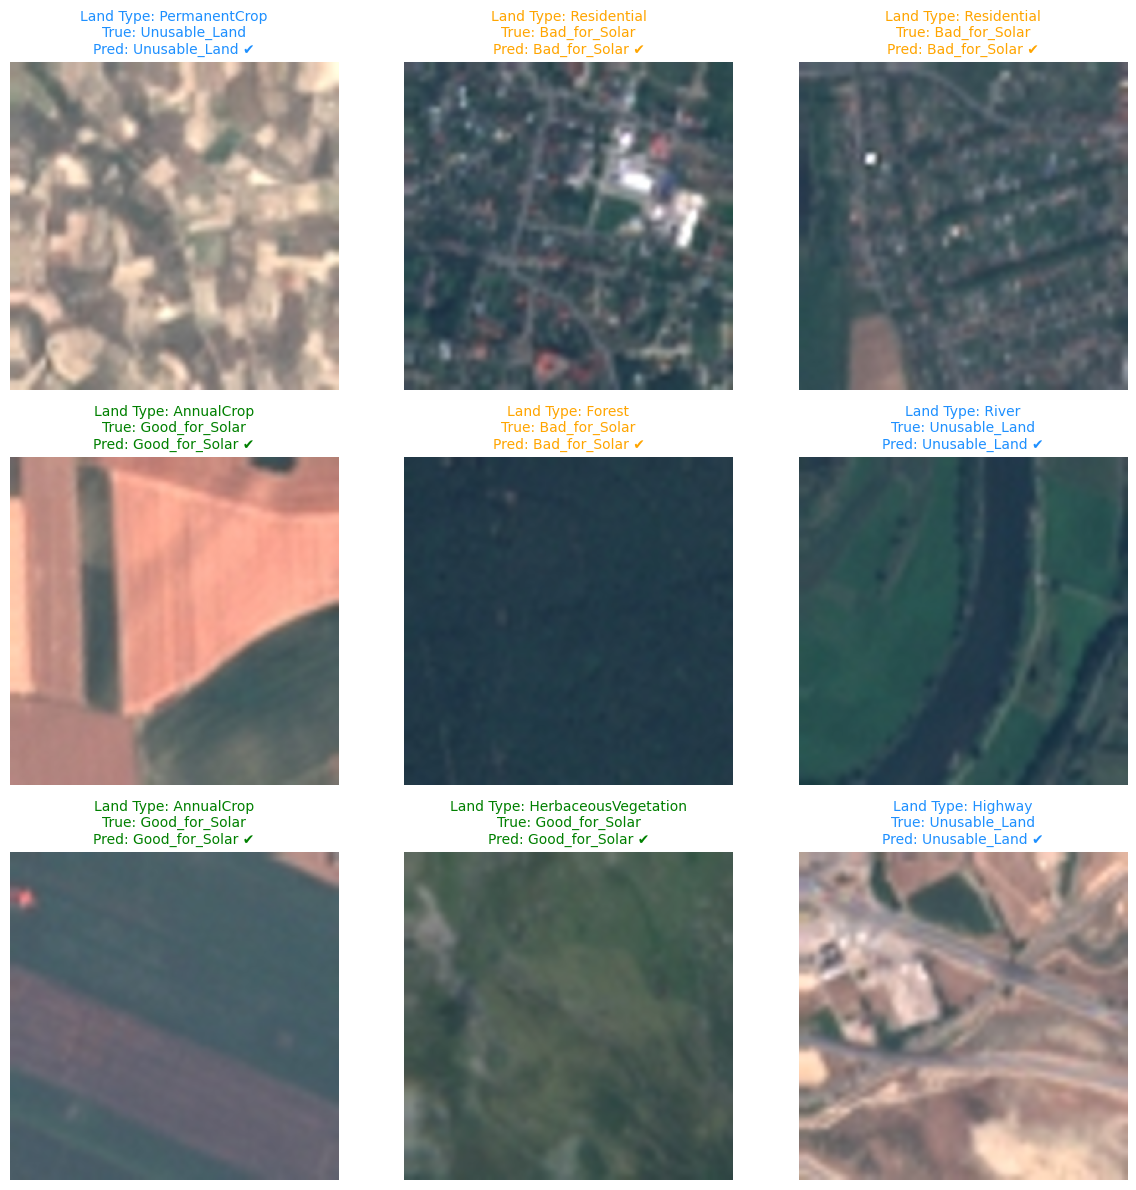

In [12]:
import numpy as np

# 1. Get one RANDOM batch of images and ORIGINAL labels from the test set
for images, original_labels in ds_test.shuffle(1000).take(1):

    # 2. Get the model's predictions (for the 3 new classes)
    predictions = model.predict(images)

    # 3. Show the first 9 images and their labels
    plt.figure(figsize=(12, 12))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        # --- START OF CHANGES ---

        # A. Get the PREDICTED new name (e.g., 'Good_for_Solar')
        predicted_class_index = np.argmax(predictions[i])
        predicted_new_name = NEW_CLASS_NAMES[predicted_class_index]

        # B. Get the ORIGINAL label name (e.g., 'Forest')
        original_label_index = original_labels[i].numpy()
        original_class_name = ORIGINAL_CLASS_NAMES[original_label_index]

        # C. Get the TRUE new name (by running our logic)
        true_new_index = map_label_logic(original_labels[i])
        true_new_name = NEW_CLASS_NAMES[true_new_index]

        # Set the title color based on the PREDICTION
        if predicted_new_name == 'Good_for_Solar':
            title_color = 'green'
        elif predicted_new_name == 'Bad_for_Solar':
            title_color = 'orange'
        else: # This will be 'Unusable_Land'
            title_color = 'dodgerblue' # A nice, clear blue

        # Add a marker for correctness
        if predicted_new_name == true_new_name:
            marker = '✔'
        else:
            marker = '❌'

        # Update the title to be more descriptive
        plt.title(f"Land Type: {original_class_name}\nTrue: {true_new_name}\nPred: {predicted_new_name} {marker}",
                  color=title_color,
                  fontsize=10)

        # --- END OF CHANGES ---

        plt.axis("off")

plt.tight_layout()
plt.show()

Saving AD_4nXfvZxz8gbmzXv9OaaZ3EOkk9cRubO3vVQF01nF6fK26RYa-OQUpvGWQP5UZ6eJMqgbNpn3hdOkFRs9SsMHWAA-uQBwL4l74DzA--B5ZIBeqj_au1vD229QA1Emq9oV2SJ3hVgtt9w.webp to AD_4nXfvZxz8gbmzXv9OaaZ3EOkk9cRubO3vVQF01nF6fK26RYa-OQUpvGWQP5UZ6eJMqgbNpn3hdOkFRs9SsMHWAA-uQBwL4l74DzA--B5ZIBeqj_au1vD229QA1Emq9oV2SJ3hVgtt9w.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


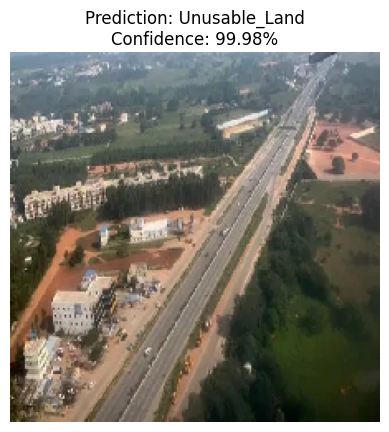

In [15]:
from google.colab import files
from tensorflow.keras.preprocessing import image as keras_image

# 1. Create the upload button
uploaded_files = files.upload()

# 2. Loop through all the files you uploaded
for file_name in uploaded_files.keys():
    # 3. Load the image from the file
    img = keras_image.load_img(file_name, target_size=IMG_SIZE)

    # 4. Convert the image to a format the model understands
    img_array = keras_image.img_to_array(img)
    img_array = img_array / 255.0 # Normalize the pixels
    img_batch = np.expand_dims(img_array, axis=0) # Create a "batch" of 1 image

    # 5. Make the prediction
    prediction = model.predict(img_batch)

    # 6. Get the result
    predicted_class_index = np.argmax(prediction[0])
    predicted_class_name = NEW_CLASS_NAMES[predicted_class_index]
    confidence = np.max(prediction[0]) * 100

    # 7. Display the image and the result
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class_name}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()

In [13]:
# Save the entire model to a single file.
# The .keras format is the new standard and saves everything.
model.save('my_land_use_model.keras')

print("Model saved to my_land_use_model.keras")

Model saved to my_land_use_model.keras
